In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def _build_model(ac_dim, ob_dim):
    
    np.random.seed(123)
    
    ip = Input(shape = (ob_dim), name = 'input')
     
    x = Dense(256, activation = 'linear')(ip)
      
    op = Dense(ac_dim, activation = 'softmax')(x)
        
    model = Model(ip, op)
    print(model.summary())
    model.compile(Adam(), 'mse', metrics=['accuracy'])
    return model
        
def loss(pred, true, l='logloss'):
    
    if l in 'logloss':
        r = -np.mean(true*np.log(pred+0.00001))
    elif l in 'mse':
        r = np.sum(np.square(true - pred))
    #print(pred, true, r)
    return r

def get_mini_batches(X, Y, batch_size):
    mini_batch = []
    data = np.hstack((X,Y))
    np.random.shuffle(data)
    n_batches = data.shape[0]//batch_size
    onehotencoder = OneHotEncoder(categories='auto')
    i=0
    
    for i in range(n_batches+1):
        minibatch = data[i*batch_size:(i+1)*batch_size, :]
        x = minibatch[:, :-1]
        y = minibatch[:, -1].reshape(-1,1)
        onehot_y = onehotencoder.fit_transform(y).toarray()
        mini_batch.append((x, onehot_y))
        
    if data.shape[0] % batch_size!=0:
        minibatch = data[i*batch_size:data.shape[0], :]
        x = minibatch[:, :-1]
        y = minibatch[:, -1].reshape(-1,1)
        onehot_y = onehotencoder.fit_transform(y).toarray()
        mini_batch.append((x, onehot_y))
        
    return mini_batch


def F(train_data, train_labels, model, params):
    
    r = 0
    num_runs = 1
    batch_size = params['batch_size']
    for j in range(num_runs): 
        
        #state = train_data.iloc[0:batch_size,:]   
        #true_value = train_labels.values[0:batch_size]
        
        mini_batch = get_mini_batches(train_data, train_labels, batch_size)    
        #stime = time.time()
        for mb in mini_batch:

            state, true_value = mb
            #state = np.reshape(state, (batch_size,784))
            actions = model.predict(state)
            reward = -loss(actions, true_value, 'mse')
            r += reward   
            #state = train_data.iloc[i*batch_size+1:(i+1)*batch_size]
        #print('Took ', time.time()-stime, ' for 1 pass')
    return np.sum(r)/num_runs


In [0]:
def train(params):
    print('training with params{}'.format(params))
    train_df = pd.read_csv('/content/drive/My Drive/es/mnist_train.csv')
    np.random.seed(params['seed'])
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    n = train_df.shape[0]
    idx = int(0.8*n)
    print('Training size:', idx, ' Validation size:', n-idx)
    train_labels = train_df.iloc[0:idx,0].to_frame()        
    valid_labels = train_df.iloc[idx:n,0].to_frame()        
    
    train_data = train_df.iloc[0:idx,1:]/255        
    valid_data = train_df.iloc[idx:n,1:]/255     
    
    test_df = pd.read_csv('/content/drive/My Drive/es/mnist_test.csv')
    test_labels = test_df.iloc[:,0].to_frame()        
    test_data = test_df.iloc[:,1:]/255        
    
    
    params['ac_dim'] = 10
    params['ob_dim'] = train_data.shape[1]
    
    model = _build_model(params['ac_dim'], params['ob_dim'])
    try:
        model.load_weights('/content/drive/My Drive/es/weights/weights_vanilla_0.05_20_500.h5')
        print('Loaded pretrained weights.')
    except:
        print('New Model...')
    learning_rate = params['learning_rate']
    sigma = params['sigma']
    n = 20
    iter_reward = []
    ts = 0

    #####
    df = pd.DataFrame(columns=['test_Reward', 
                            'valid_Reward', 
                            'train_Reward', 
                            'Timesteps', 
                            'iter', 
                            'policy', 
                            'reward_norm'
                            ])
        
    #####

    for n_iter in range(params['max_iter']+1):
        stime = time.time()
        
        r1, r2 = [], []
        theta = model.get_weights()
        g = []
        for i in range(n):
            x = []
            for w in theta:
                x.append(np.random.randn(*w.shape)*sigma)
            g.append(x)
        


        ###########################
        vr = F(valid_data, valid_labels, model, params)
        tr = F(train_data, train_labels, model, params)
        testr = F(test_data, test_labels, model, params)
        iter_reward.append(vr)
        if n_iter % 1 == 0:
            print('iter:{}, rewards:{}, test:{}'.format(n_iter, vr, testr))
        
        # save to csv
        df = df.append({'test_Reward': testr,
                   'valid_Reward': vr,
                   'train_Reward': tr, 
                   'Timesteps': ts, 
                   'iter':n_iter, 
                   'policy': params['policy'], 
                   'reward_norm':params['reward_norm']
                   }, ignore_index=True)
        df.to_csv('/content/drive/My Drive/es/data/%s/results/%s_Seed%s.csv' %(params['dir'], params['filename'], params['seed']))
    
        ########################
        
        # ES baselines (vanilla, antithetic, forward finite difference)
        # vanilla: f(theta + sigma*gi)
        # antithetic: f(theta + sigma*gi) + f(theta - sigma*gi)
        # ffd: f(theta + sigma*gi) - f(theta )
        for i in range(n):
            #stime = time.time()
            if params['policy'] in 'vanilla':
                theta1 = np.add(theta, g[i])
                model.set_weights(theta1)
                r1.append(F(train_data, train_labels, model, params)) 

            if params['policy'] in 'antithetic':
                theta1 = np.add(theta, g[i])
                model.set_weights(theta1)
                r1.append(F(train_data, train_labels, model, params))

                theta2 = np.subtract(theta, g[i])
                model.set_weights(theta2)
                r2.append(F(train_data, train_labels, model, params))

            if params['policy'] in 'ffd':                
                theta1 = np.add(theta, g[i])
                model.set_weights(theta1)
                r1.append(F(train_data, train_labels, model, params))
                
                model.set_weights(theta)
                r2.append(F(train_data, train_labels, model, params))


            #print('took:', time.time()-stime, 'for one pertubation')
            #break
        if params['policy'] in 'vanilla':
            R = r1
        if params['policy'] in ('antithetic', 'ffd'):
            R = np.subtract(r1, r2)

        # Augmented random search with reward renormalization
        if params['reward_norm']:
            R = (R - np.mean(R))/np.std(R)

        for index, w in enumerate(theta):
                A = np.array([p[index] for p in g])
                theta[index] = w + learning_rate/(2*sigma*n) * np.dot(A.T, R).T
        
        #grad = np.sum(R*g)/(2*sigma*n)
        #theta += learning_rate * grad
        model.set_weights(theta)
        #if n_iter % 50 == 0:
        model.save_weights('/content/drive/My Drive/es/weights/weights_vanilla_0.05_20_500.h5')
        ts += n
        
        print('took:', time.time()-stime, 'for iteration ', n_iter)
        print('--------------------------------------------------')
                
    plt.plot(iter_reward)


In [0]:
def test(params):
    print('testing with params{}'.format(params))
    np.random.seed(params['seed'])
    
    test_df = pd.read_csv('/content/drive/My Drive/es/mnist_test.csv')
    test_labels = test_df.iloc[:,0].to_frame()        
    test_data = test_df.iloc[:,1:]/255        
    
    params['ac_dim'] = 10
    params['ob_dim'] = test_data.shape[1]
    
    model = _build_model(params['ac_dim'], params['ob_dim'])
    try:
        model.load_weights('/content/drive/My Drive/es/weights/weights_vanilla_0.05_20_500.h5')
        print('Loaded pretrained weights.')
    except:
        raise('Model weights not found...stopping!')
        
    
    learning_rate = 0.05
    sigma = 0.1
    n = 20
    iter_reward = []
        
    for n_iter in range(1, params['max_iter']+1):
        
        stime = time.time()
        ###########################
        testr = F(test_data, test_labels, model, params)
        iter_reward.append(testr)
        if n_iter % 1 == 0:
            print('iter:{}, rewards:{}'.format(n_iter, testr))
        ########################
        print('took:', time.time()-stime, 'for iteration ', n_iter)
        print('--------------------------------------------------')
            
    plt.plot(iter_reward)

    ## TO ADD evaluate function for accuracy
    #model.evaluate(valid_data, onehot_y)
    

testing with params{'max_iter': 200, 'batch_size': 512, 'seed': 123, 'learning_rate': 0.05, 'sigma': 0.1, 'env_name': 'mnist', 'policy': 'vanilla', 'reward_norm': True, 'filename': 'mnist', 'dir': 'mnist_vanilla_mnist'}
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________
None
Loaded pretrained weights.
iter:1, rewards:-3163.132098752286
took: 1.8814101219177246 for iteration  1
--------------------------------------------------
ite

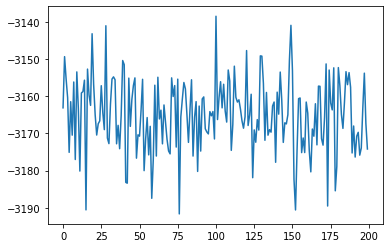

In [10]:
def main():
    params = {
        'max_iter': 200,
        'batch_size' : 512,
        'seed' : 123,
        'learning_rate' : 0.05,
        'sigma' : 0.1, 
        'env_name' : 'mnist',
        'policy' : 'vanilla', # vanilla, antithetic, ffd
        'reward_norm' : True, # normalize rewards
        'filename' : 'mnist'
        }
    params['dir'] = params['env_name'] + '_' + params['policy'] + '_' + params['filename']
    
    espath = '/content/drive/My Drive/es/'
    if not(os.path.exists(espath+'data/'+params['dir'])):
        os.makedirs(espath+'data/'+params['dir'])
        os.makedirs(espath+'data/'+params['dir']+'/results')
    
    training = False

    if training:
        train(params)
    else:
        test(params)
    
if __name__ == '__main__':
    main()


In [0]:


test_df = pd.read_csv('/content/drive/My Drive/es/mnist_test.csv')
test_labels = test_df.iloc[:,0].to_frame()        
test_data = test_df.iloc[:,1:]/255  
onehotencoder = OneHotEncoder(categories='auto')
onehot_y = onehotencoder.fit_transform(test_labels).toarray()    

In [13]:
model1 = _build_model(10, 784)
try:
    model1.load_weights('/content/drive/My Drive/es/weights/weights_vanilla_0.05_20_500.h5')
    print('Loaded pretrained weights.')
except:
    raise('Model weights not found...stopping!')
    

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                2570      
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________
None
Loaded pretrained weights.


In [14]:
model1.evaluate(test_data, onehot_y)



10000/10000 [==============================] - 0s 47us/sample - loss: 0.0308 - acc: 0.8001


[0.03082062334883958, 0.8001]